In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import os
import cv2
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
#tf.__version__
from tensorflow.python.client import device_lib

from sklearn import preprocessing

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

In [121]:

model = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(None, None, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [118]:
def load_img(img_path,img_shape, preprocess=True):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path)#, target_size=(img_rows, img_cols))    
    if preprocess:
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

        img =  preprocess_input(img)
        return img

    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return np.array(img, dtype=np.uint8)

In [5]:
def lap_mag(channels):
    laps = []
    print(channels.shape)
    for i in range(channels.shape[-1]):
        
        dst = cv2.Laplacian(channels[:,:,i], cv2.CV_32F , 3)
        laps.append(dst)
    mag = np.linalg.norm(laps, axis = 0)
    return mag

In [6]:
def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

In [7]:
def local_arg_max(mat, window_size):
    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    k = int(np.floor(window_size/2))
    print(k)
    for i in range(k, mat.shape[0]-k, window_size):
        for j in range(k, mat.shape[1]-k, window_size):

            window = mat[i-k:i+k+1, j-k:j+k+1]
            coords = np.argwhere(window==window.max())
            
            idx.extend(coords + [i-k, j-k])

    return  np.unique(idx, axis=0)  

In [132]:
def get_keypoints_and_descriptor(image_path):

    img = load_img(image_path, [224,224])
    img_no_proc = load_img(image_path, [224,224], preprocess=False)
    #keypoint_coords = np.array([])


    input_layer = get_cnn_out(img, 0)  

    layer_1 = get_cnn_out(img, 1)  
    layer_2 =  get_cnn_out(img, 2)
    block_1 = (lap_mag(layer_1) +  lap_mag(layer_2)) /2
    layer_output = np.stack([layer_1, layer_2])
    
    pool_1 =  np.stack([get_cnn_out(img, 3)])
    pool_2 =  np.stack([get_cnn_out(img, 6)])
    pool_3 =  np.stack([get_cnn_out(img, 10)])[0]

    keypoint_coords = local_arg_max(block_1, 3)
    #layer_output = np.stack([layer_1, layer_2])

    k=[]
    d=[]
    gray = cv2.cvtColor(img_no_proc,cv2.COLOR_BGR2GRAY)
    r = cv2.cornerHarris(gray,5,5,0.04, cv2.BORDER_ISOLATED)
    r = cv2.dilate(r,None)
    for row, col in keypoint_coords:
        #print(float(row), float(col))
        if r[row,col]  > 0.03*np.amax(r) : #if pixel is not on edge

            keypoint = cv2.KeyPoint()
            keypoint.pt = (float(col), float(row))
            keypoint.octave = 0
            keypoint.size = 0
            keypoint.response = 0
            k.append(keypoint)
            print(pool_3.shape)
            d0 = np.array(img_no_proc[row, col ]).flatten()
            d1 = np.array(layer_output[:, row, col ]).flatten()
            d1 = d1/np.std(d1)
            d2 = np.array(pool_1[:, round(row/2)-1, round(col/2)-1 ]).flatten()
            d2 = d2/np.std(d2)
            d3 = np.array(pool_2[:, round(row/4)-1, round(col/4)-1 ]).flatten()
            d4 = np.array(pool_3[:, round(row/8)-1, round(col/8)-1 ]).flatten()

            print(layer_2.shape)
            d.append(np.concatenate([d0, d1]))

    return np.array(k), np.array(d)

Startin
(480, 640, 64)
(480, 640, 64)
1
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60, 80, 256)
(480, 640, 64)
(60

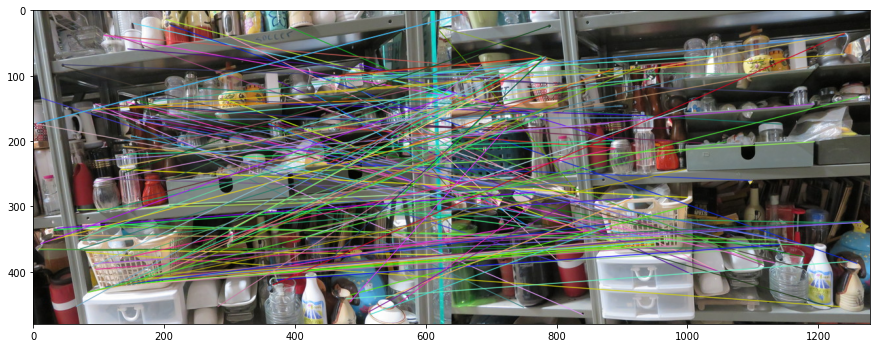

(<matplotlib.image.AxesImage at 0x1f0139d7d60>, None)

In [133]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]

data_path1= './SYS809_projet2021_sequences1/new_livre1.jpg' #'./SYS809_projet2021_sequences1/new_livre1.JPG'
data_path2='./SYS809_projet2021_sequences1/livre2.jpg' # './SYS809_projet2021_sequences1/livre2.JPG'

data_path1= './SYS809_projet2021_sequences1/magasinA-02.jpg'  #'./SYS809_projet2021_sequences1/livre1_old.JPG'
data_path2=  './SYS809_projet2021_sequences1/magasinB-02.jpg'


print("Startin")
img_shape=[224,224]
#img1 = load_img(data_path1,img_shape).copy()
#img2 = load_img(data_path2,img_shape).copy()

#plt.imshow(img1[0])


kp1,des1 = get_keypoints_and_descriptor(data_path1)
kp2,des2 = get_keypoints_and_descriptor(data_path2)
print("Got kp1 and desc1", kp1.shape, des1.shape)
print("Got kp2 and desc2", len(kp2), len(des2))

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

#knnMatch retourne les 2 plus proche voisin pour chaque membre de des1
matches = flann.knnMatch(des1,des2,k=2)
#Les objects DMatch contiennent index de du point-cle de ds1 match dans le champ queryIdx
#et l'index du point-cle appartenant a des2 dans le champ trainIdx
print("Done Match")

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
print("len match:", len(matches))

# ratio test as per Lowe's paper,
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < .7 * n.distance:
        good.append(m)
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = -1, #(0,255,0),
                   singlePointColor = (0,0,0),
                   matchesMask = matchesMask,
                   flags = 2|4)

img1 = load_img(data_path1,img_shape, preprocess=False)
img2 = load_img(data_path2,img_shape, preprocess=False)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None, **draw_params )

print("len match:", len(matches))
print("len good:", len(good))

plt.figure(figsize=(15, 15))
plt.imshow(img3),plt.show()

In [50]:
arr = np.array([[[1,2,3,4],[3,4,5,6],[8,7,5,3],[7,5,3,2]], [[5,4,2,1],[10,11,12,13],[77,66,55,44], [88,99,66,44]] ])
arr.shape

(2, 4, 4)